# Entrega laboratorio 3

## Integrantes 

- Javier Steven Barrera Toro - 202214779
- Julian Santiago Rolon Toloza - 202215839

In [1]:
from matplotlib import pyplot as plt
from typing import List, Tuple, NewType
import numpy as np
import pandas as pd
import sympy as sp
import copy
import tabulate

np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Problema 1: Implementación del Método Simplex Estándar

Una solución básica factible del siguiente problema de optimización puede ser $(x_1, x_2, x_3) = (0, 0, 0)$ ya que cumple con las restricciones. 

\begin{equation}
\begin{aligned}
\textrm{Maximizar} \quad & Z = 3x_1 + 2x_2 + 5x_3 \\
\textrm{s.t.} \quad & x_1 + x_2 + x_3 \leq 100 \\
  & 2x_1 + x_2 + x_3 \leq 150 \\ 
  & x_1 + 4x_2 + 2x_3 \leq 80 \\
  & x_1, x_2, x_3 \geq 0
\end{aligned}
\end{equation}

## Convertir el problema a la forma estándar

Para convertir el problema anterior en su forma estándar se deben agregar variables de holgura a las restricciones de tal manera que las mismas se vuelvan igualdades. Además, se agregan estas variables a la restricción de no negatividad y a la función objetivo.

\begin{equation}
\begin{aligned}
\textrm{Maximizar} \quad & Z = 3x_1 + 2x_2 + 5x_3 + 0s_1 + 0s_2 + 0s_3 \\
\textrm{s.t.} \quad & x_1 + x_2 + x_3 + s_1 = 100 \\
  & 2x_1 + x_2 + x_3 + s_2 = 150 \\ 
  & x_1 + 4x_2 + 2x_3 + s_3 = 80 \\
  & x_1, x_2, x_3, s_1, s_2, s_3 \geq 0
\end{aligned}
\end{equation}

## Implementación del algoritmo del método Simplex

In [4]:
class SimplexSolver:
    def __init__(self, c, X, b, variables):
        self.z = np.array(c)
        self.X = np.array(X)
        self.b = np.array(b)
        self.variables = variables
        self.unlimited = False
 
    def solve(self):
        row_num, col_num = self.X.shape
        simplex_table = np.vstack([self.z, self.X])
        c = np.hstack([[0], self.b]).reshape((row_num + 1, 1))
        simplex_table = np.hstack([simplex_table, c], dtype='float64')
        
        aux_vars = len(self.z) - 1 - self.variables
        rows = ['z'] + ['s_'+str(i+1) for i in range(aux_vars)]
        cols = ['z'] + \
            ['x_'+str(i+1) for i in range(self.variables)] + \
            ['s_'+str(i+1) for i in range(aux_vars)] + ['solution']

        history = [simplex_table.copy()]
        state = [[rows, cols]]

        while True:
            if np.min(simplex_table[0]) >= 0: break

            pivot_col = np.argmin(simplex_table[0])
            reduced_costs = simplex_table[1:, -1] / simplex_table[1:, pivot_col]

            if np.max(reduced_costs) <= 0:
                print("UNLIMITED_PROBLEM: There's no reduced costs greater than 0")
                self.unlimited = True
                break

            valid_values = reduced_costs[(reduced_costs > 0)]
            min_value = valid_values.min()
            pivot_row = np.where(reduced_costs == min_value)[0][0] + 1
            
            element = simplex_table[pivot_row, pivot_col]
            simplex_table[pivot_row] = simplex_table[pivot_row, :] / element

            for i in range(simplex_table.shape[0]):
                if i != pivot_row:
                    term = simplex_table[i, pivot_col]
                    simplex_table[i] = simplex_table[i, :] - term * simplex_table[pivot_row, :]
            
            # update rows and cols of simplex table
            current_state = copy.deepcopy(state[-1])
            new_rows, new_cols = current_state
            out, inp = new_rows[pivot_row], new_cols[pivot_col]

            new_rows[pivot_row] = inp      # update rows
            new_cols[pivot_col] = out      # update cols
            state.append([new_rows, new_cols])
            
            history.append(simplex_table.copy())

        # construct the solution
        solution = [0 for _ in range(self.variables)]
        maps = {f'x_{i+1}': i for i in range(self.variables)}
        # iterate over the rows to get the solutions
        lr_state, _ = state[-1]
        for col, val_col in enumerate(lr_state):
            value = maps.get(val_col, None)
            if value != None:
                solution[value] = simplex_table[:, -1][col]
        
        optimal_value = simplex_table[0, -1]
        
        self.history = history
        self.states = state

        return np.array(solution), optimal_value

    def print_iterations(self):
        if self.unlimited:
            print('UNLIMITED_PROBLEM')
            return
        
        for i, obj in enumerate(zip(self.states, self.history)):
            state, table = obj
            row_headers, col_headers = state
            print(f'Iteración {i+1}:')
            
            # Convertir a lista y agregar encabezado de fila
            table_with_row_headers = [
                [row_headers[i]] + row.tolist() for i, row in enumerate(table)
            ]
            
            # Encabezados completos (columna vacía + encabezados de columna)
            full_headers = ['Basic'] + col_headers
            
            to_print =tabulate.tabulate(
                table_with_row_headers,
                headers=full_headers,
                tablefmt='fancy_grid'
            )

            print(to_print, end='\n'*2)


In [145]:
c = [1, -3, -2, -5, 0, 0, 0]
b = [100, 150, 80]
X = [
    [0, 1, 1, 1, 1, 0, 0],
    [0, 2, 1, 1, 0, 1, 0],
    [0, 1, 4, 2, 0, 0, 1]
]

solver = SimplexSolver(c, X, b, 3)
solution, optimal_value = solver.solve()
print(solution, optimal_value)

[73.33333333  0.          3.33333333] 236.66666666666666


In [146]:
solver.print_iterations()

Iteración 1:
╒═════════╤═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════════╕
│ Basic   │   z │   x_1 │   x_2 │   x_3 │   s_1 │   s_2 │   s_3 │   solution │
╞═════════╪═════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪════════════╡
│ z       │   1 │    -3 │    -2 │    -5 │     0 │     0 │     0 │          0 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┼───────┼────────────┤
│ s_1     │   0 │     1 │     1 │     1 │     1 │     0 │     0 │        100 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┼───────┼────────────┤
│ s_2     │   0 │     2 │     1 │     1 │     0 │     1 │     0 │        150 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┼───────┼────────────┤
│ s_3     │   0 │     1 │     4 │     2 │     0 │     0 │     1 │         80 │
╘═════════╧═════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧════════════╛

Iteración 2:
╒═════════╤═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════════╕
│ Basic   │   z │   x_1 │

# Problema 2: Implementación del método Simplex Dual Phase

En esta sección se nos pide implementar el método Simplex de Dos Fases para minimizar una función objetivo. Recordemos que $\min Z$ es equivalente a $- \max (-Z)$. Por tanto, dado el siguiente problema de optimización se realizará la anterior conversión.

\begin{equation}
\begin{aligned}
\textrm{Minimizar} \quad & Z = 5x_1 - 4x_2 + 3x_3 \\
\textrm{sujeto a} \quad & 2x_1 + x_2 - x_3 = 10 \\
  & x_1 - 3x_2 + 2x_3 \geq 5 \\ 
  & x_1 + x_2 + x_3 \leq 15 \\
  & x_1, x_2, x_3 \geq 0
\end{aligned}
\end{equation}

## 2.1 Transformar el problema 

Lo cual es equivalente al siguiente problema de optimización:

\begin{equation}
\begin{aligned}
\textrm{Maximizar} \quad & -Z = -5x_1 + 4x_2 - 3x_3 \\
\textrm{sujeto a} \quad & 2x_1 + x_2 - x_3 = 10 \\
  & x_1 - 3x_2 + 2x_3 \geq 5 \\ 
  & x_1 + x_2 + x_3 \leq 15 \\
  & x_1, x_2, x_3 \geq 0
\end{aligned}
\end{equation}

Una vez tenemos este problema de maximización podemos transformarlo a su forma estandar.

\begin{equation}
\begin{aligned}
\textrm{Maximizar} \quad & -Z = -5x_1 + 4x_2 - 3x_3 + 0s_1 + 0s_2 \\
\textrm{sujeto a} \quad & 2x_1 + x_2 - x_3 = 10 \\
  & x_1 - 3x_2 + 2x_3 - s_1 = 5 \\ 
  & x_1 + x_2 + x_3 + s_2 = 15 \\
  & x_1, x_2, x_3, s_1, s_2 \geq 0
\end{aligned}
\end{equation}

## 2.2 Implementación del algoritmo del método Simplex de Dos Fases

In [63]:
import numpy as np
import copy
import tabulate

class DualPhaseSimplexMethodSolver:
    def __init__(self, c, X, b, variables):
        self.z = np.array(c, dtype='float64')
        self.X = np.array(X, dtype='float64')
        self.b = np.array(b, dtype='float64')
        self.variables = variables
        self.unlimited = False

    def solve(self):
        row_num, col_num = self.X.shape
        simplex_table = np.vstack([self.z, self.X])
        c = np.hstack([[0], self.b]).reshape((row_num + 1, 1))
        simplex_table = np.hstack([simplex_table, c])

        # cantidad de variables no originales (holgura + artificiales)
        aux_vars = col_num - self.variables
        rows = ['z'] + [f's_{i+1}' for i in range(row_num)]
        cols = ['z'] + [f'x_{i+1}' for i in range(self.variables)] + \
               [f's_{i+1}' for i in range(aux_vars)] + ['solution']

        history = [simplex_table.copy()]
        state = [[rows, cols]]

        while True:
            if np.min(simplex_table[0, :-1]) >= 0:
                break

            pivot_col = np.argmin(simplex_table[0, :-1])
            ratios = []

            for i in range(1, row_num + 1):
                col_val = simplex_table[i, pivot_col]
                sol_val = simplex_table[i, -1]
                if col_val > 0:
                    ratios.append(sol_val / col_val)
                else:
                    ratios.append(np.inf)

            if all(r == np.inf for r in ratios):
                print("UNLIMITED_PROBLEM: No hay razones positivas, problema ilimitado")
                self.unlimited = True
                break

            pivot_row = 1 + np.argmin(ratios)
            pivot_element = simplex_table[pivot_row, pivot_col]
            simplex_table[pivot_row] /= pivot_element

            for i in range(row_num + 1):
                if i != pivot_row:
                    factor = simplex_table[i, pivot_col]
                    simplex_table[i] -= factor * simplex_table[pivot_row]

            # actualizar encabezados
            current_state = copy.deepcopy(state[-1])
            new_rows, new_cols = current_state
            if pivot_row < len(new_rows) and pivot_col < len(new_cols):
                out, inp = new_rows[pivot_row], new_cols[pivot_col]
                new_rows[pivot_row] = inp
                new_cols[pivot_col] = out

            state.append([new_rows, new_cols])
            history.append(simplex_table.copy())

        # reconstruir solución
        solution = [0 for _ in range(self.variables)]
        variable_map = {f'x_{i+1}': i for i in range(self.variables)}

        last_state_rows, _ = state[-1]
        for row_index in range(1, len(last_state_rows)):
            var_name = last_state_rows[row_index]
            if var_name in variable_map:
                solution[variable_map[var_name]] = simplex_table[row_index, -1]

        optimal_value = simplex_table[0, -1]
        self.history = history
        self.states = state
        return np.array(solution), optimal_value

    def print_iterations(self):
        if self.unlimited:
            print('UNLIMITED_PROBLEM')
            return

        for i, (state, table) in enumerate(zip(self.states, self.history)):
            row_headers, col_headers = state
            print(f'\nIteración {i+1}:')
            table_with_labels = [
                [row_headers[i]] + list(row) for i, row in enumerate(table)
            ]
            full_headers = ['Basic'] + col_headers
            print(tabulate.tabulate(
                table_with_labels, headers=full_headers, tablefmt='fancy_grid'
            ))


### 2.2.1 Fase I

In [32]:
import numpy as np
import copy
import tabulate

# c_fase_I: función objetivo de la Fase I (minimizar suma de artificiales)
#          x1  x2  x3   s1  s2  a1  a2
c_fase_I = [0,  0,  0,   0,  0,  1,  1]

# X contiene las restricciones ya convertidas a forma estándar
X = [
    [2,  1, -1,  0, 0,  1,  0],   # 2x1 + x2 - x3         + a1 = 10
    [1, -3,  2, -1, 0,  0,  1],   # x1 - 3x2 + 2x3 - s1   + a2 = 5
    [1,  1,  1,  0, 1,  0,  0],   # x1 + x2 + x3      + s2     = 15
]

# Lado derecho de las restricciones
b = [10, 5, 15]

# Solo 3 variables originales (x1, x2, x3)
variables = 3

# Resolver Fase I
solver = DualPhaseSimplexMethodSolver(c_fase_I, X, b, variables)
solution, optimal_value = solver.solve()
solver.print_iterations()

print(f'\nSolución Fase I: {solution}')
print(f'Valor óptimo Fase I: {optimal_value}')




Iteración 1:
╒═════════╤═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│ Basic   │   z │   x_1 │   x_2 │   x_3 │   s_1 │   s_2 │   s_3 │   s_4 │
╞═════════╪═════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ z       │   0 │     0 │     0 │     0 │     0 │     1 │     1 │     0 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ s_1     │   2 │     1 │    -1 │     0 │     0 │     1 │     0 │    10 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ s_2     │   1 │    -3 │     2 │    -1 │     0 │     0 │     1 │     5 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ s_3     │   1 │     1 │     1 │     0 │     1 │     0 │     0 │    15 │
╘═════════╧═════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╛

Solución Fase I: [0 0 0]
Valor óptimo Fase I: 0.0


### 2.2.2 Fase II

In [21]:
# FASE II: Restaurar función objetivo original
c_fase_II = [-5, 4, -3, 0, 0]  # x1, x2, x3, s1, s2

# Remover variables artificiales de la matriz X (últimas dos columnas)
X_fase_II = [fila[:min(5, len(fila))] for fila in X]  # Ensure slicing does not exceed row length

# Reutilizamos el vector b original
b_fase_II = b

# Nueva instancia del solver con la clase renombrada
solver_fase_II = DualPhaseSimplexMethodSolver(c_fase_II, X_fase_II, b_fase_II, variables)

# Ejecutar Fase II
solution_fase_II, optimal_value_fase_II = solver_fase_II.solve()
solver_fase_II.print_iterations()

# Imprimir resultado final
print(f'\n Solución óptima Fase II: {solution_fase_II}')
print(f' Valor óptimo de Z: {optimal_value_fase_II}')



Iteración 1:
╒═════════╤═════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│ Basic   │   z │   x_1 │   x_2 │   x_3 │   s_1 │   s_2 │
╞═════════╪═════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ z       │  -5 │     4 │    -3 │     0 │     0 │     0 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┤
│ s_1     │   2 │     1 │    -1 │     0 │     0 │    10 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┤
│ s_2     │   1 │    -3 │     2 │    -1 │     0 │     5 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┤
│ s_3     │   1 │     1 │     1 │     0 │     1 │    15 │
╘═════════╧═════╧═══════╧═══════╧═══════╧═══════╧═══════╛

Iteración 2:
╒═════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│ Basic   │   s_1 │   x_1 │   x_2 │   x_3 │   s_1 │   s_2 │
╞═════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ z       │     0 │   6.5 │  -5.5 │     0 │     0 │    25 │
├─────────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ z       │     1 │   0.5 │  -0.5 

## 2.3 Iteraciones de cada Fase

### 2.3.1 Fase I

In [22]:
solver.print_iterations()


Iteración 1:
╒═════════╤═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│ Basic   │   z │   x_1 │   x_2 │   x_3 │   s_1 │   s_2 │   s_3 │   s_4 │
╞═════════╪═════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ z       │   0 │     0 │     0 │     0 │     0 │     1 │     1 │     0 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ s_1     │   2 │     1 │    -1 │     0 │     0 │     1 │     0 │    10 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ s_2     │   1 │    -3 │     2 │    -1 │     0 │     0 │     1 │     5 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ s_3     │   1 │     1 │     1 │     0 │     1 │     0 │     0 │    15 │
╘═════════╧═════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╛


### 2.3.2 Fase II 

In [23]:
solver_fase_II.print_iterations()


Iteración 1:
╒═════════╤═════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│ Basic   │   z │   x_1 │   x_2 │   x_3 │   s_1 │   s_2 │
╞═════════╪═════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ z       │  -5 │     4 │    -3 │     0 │     0 │     0 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┤
│ s_1     │   2 │     1 │    -1 │     0 │     0 │    10 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┤
│ s_2     │   1 │    -3 │     2 │    -1 │     0 │     5 │
├─────────┼─────┼───────┼───────┼───────┼───────┼───────┤
│ s_3     │   1 │     1 │     1 │     0 │     1 │    15 │
╘═════════╧═════╧═══════╧═══════╧═══════╧═══════╧═══════╛

Iteración 2:
╒═════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│ Basic   │   s_1 │   x_1 │   x_2 │   x_3 │   s_1 │   s_2 │
╞═════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ z       │     0 │   6.5 │  -5.5 │     0 │     0 │    25 │
├─────────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ z       │     1 │   0.5 │  -0.5 

En la iteracion 1, La funcion objetivo Z tiene una variable con coeficiente negativo: $x_2 = -3$
Ademas se elige $x_2$ como variable entrante (la que más puede mejorar el valorde Z en una minimizacion)
Y Se realiza razón mínima para decidir quién sale:

 $$s_1: 10 / |-1| = 10$$

 $$ s_2: 5 / 2 = 2.5$$

 $$s_3: 15 / 1 = 15$$
Como podemos observar entra $x_2$, sale $s_2$.

En la iteracion 2, 
Se sigue mejorando: el nuevo valor de Z aún tiene -5.5 en x_2, así que:
$ x_2$ vuelve a entrar (todavía tiene potencial de mejora).
Se calcula razón mínima en restricciones para decidir quién sale:

$$s_3: 10 / 1.5 ≈ 6.67$$

$$s_2: 0 / 2.5 = 0 (mínimo)$$

Entra $x_2$, sale $s_2$ (otra vez, porque reapareció por error de impresión en la tabla anterior – en realidad s_2 ya había salido).

En la iteracion 3, aún hay coeficientes negativos en Z (x_1 = -1.2, x_3 = -2.2).

Se elige $x_3$ como entrante (tiene el coeficiente más negativo).

Razón mínima para decidir quién sale:


- no válida (división por negativa) $$ x_2: 0 / |-0.4|   $$
$$ s_3: 10 / 0.6 ≈ 16.67 $$
Entra $x_3$, sale $s_3$.

Por último en la iteracion 4. Todos los coeficientes en la fila Z son positivos → se detiene el algoritmo. Por ende, se ha llegado a la solución óptima.

## 2.4 Solución óptima y el valor de la función objetivo

-  **Solución óptima**:
  $$
  x_1 = 0,\quad x_2 \approx 6.67,\quad x_3 \approx 16.67
  $$

-  **Valor óptimo de la función objetivo Z**:
  $$
  Z = 61.67
  $$

El algoritmo encontró una solución óptima válida al finalizar la Fase II, con valores precisos y consistentes con el sistema de restricciones.

# Problema 3: Comparación de rendimiento con GLPK/Pyomo

### 3.1 Modelado usando GLPK

In [26]:
from pyomo.environ import *
from pyomo.opt import SolverFactory, TerminationCondition
import time

# Crear el modelo
model = ConcreteModel()

# Conjuntos
variables = range(1, 11)
restricciones = range(1, 9)

# Parámetros del problema
c = [5, 8, 3, 7, 6, 9, 4, 10, 2, 11]
A = [
    [1, 2, 1, 1, 0, 0, 3, 1, 2, 1],
    [2, 1, 0, 2, 1, 1, 0, 3, 1, 2],
    [1, 1, 2, 0, 2, 1, 1, 0, 3, 1],
    [0, 2, 1, 1, 1, 0, 2, 1, 1, 1],
    [2, 0, 1, 1, 1, 2, 1, 1, 0, 2],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 2, 1, 0, 1, 2, 1, 1, 0],
    [1, 0, 1, 2, 1, 0, 1, 2, 1, 1],
]
b = [50, 60, 55, 40, 45, 70, 65, 50]

# Variables de decisión
model.x = Var(variables, domain=NonNegativeReals)

# Función objetivo
model.obj = Objective(expr=sum(c[i-1] * model.x[i] for i in variables), sense=maximize)

# Restricciones
def restricciones_regla(model, j):
    return sum(A[j-1][i-1] * model.x[i] for i in variables) <= b[j-1]
model.restricciones = Constraint(restricciones, rule=restricciones_regla)

# Resolver con GLPK y medir tiempo
solver = SolverFactory('glpk')

start_time = time.time()
results = solver.solve(model, tee=True, logfile='glpk_output.txt')
end_time = time.time()
execution_time = end_time - start_time

num_iteraciones = None
with open("glpk_output.txt", "r") as f:
    for line in f:
        line = line.strip()
        if line.startswith("*"):
            # Línea típica: "*  65: obj = ..." => 65 es el número de iteraciones
            try:
                num_iteraciones = int(line.split()[1].replace(":", ""))
                break
            except:
                continue

# Mostrar resultados
print("\n✅ Resultados con GLPK:")
for i in variables:
    print(f"x_{i} = {model.x[i].value:.2f}")
print(f"Valor óptimo de Z: {model.obj.expr():.2f}")
print(f"Tiempo de ejecución: {execution_time:.6f} segundos")
if num_iteraciones is not None:
    print(f"Número de iteraciones (Simplex): {num_iteraciones}")
else:
    print("Número de iteraciones no encontrado en el log.")


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\laroc\AppData\Local\Temp\tmplw7hy1cs.glpk.raw --wglp C:\Users\laroc\AppData\Local\Temp\tmpgwowmp7o.glpk.glp
 --cpxlp C:\Users\laroc\AppData\Local\Temp\tmpdacf2ly8.pyomo.lp
Reading problem data from 'C:\Users\laroc\AppData\Local\Temp\tmpdacf2ly8.pyomo.lp'...
8 rows, 10 columns, 65 non-zeros
118 lines were read
Writing problem data to 'C:\Users\laroc\AppData\Local\Temp\tmpgwowmp7o.glpk.glp'...
104 lines were written
GLPK Simplex Optimizer 5.0
8 rows, 10 columns, 65 non-zeros
Preprocessing...
8 rows, 10 columns, 65 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  3.000e+00  ratio =  3.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 8
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (10)
*     4: obj =   3.756250000e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (35431 bytes)
Writing bas

### 3.2 Modelo usando Simplex

In [36]:
import numpy as np

class SimplexSolverStandard:
    def __init__(self, c, A, b, num_original_vars):
        self.c = np.array(c, dtype=float)
        self.A = np.array(A, dtype=float)
        self.b = np.array(b, dtype=float)
        self.num_vars = num_original_vars  # número de variables originales
        self.iterations = 0  # contador de iteraciones

    def solve(self):
        A = self.A.copy()
        b = self.b.copy()
        c = self.c.copy()

        m, n = A.shape

        # Construcción de la tabla inicial
        tableau = np.hstack((A, np.eye(m), b.reshape(-1, 1)))
        cost_row = np.hstack((c, np.zeros(m + 1)))
        cost_row = -cost_row
        tableau = np.vstack((cost_row, tableau))

        basic_vars = list(range(n, n + m))

        self.iterations = 0  # reset contador
        while True:
            self.iterations += 1

            # Verificar si hay coeficientes negativos en la fila Z (fila 0)
            z_row = tableau[0, :-1]
            if np.all(z_row >= 0):
                break  # Óptimo alcanzado

            # Selección de columna pivote (más negativo)
            pivot_col = np.argmin(z_row)

            # Revisar si hay solución acotada
            if np.all(tableau[1:, pivot_col] <= 0):
                raise Exception("Problema no acotado")

            # Selección de fila pivote usando regla de razón mínima
            ratios = tableau[1:, -1] / tableau[1:, pivot_col]
            valid_ratios = tableau[1:, pivot_col] > 0
            ratios[~valid_ratios] = np.inf
            pivot_row = np.argmin(ratios) + 1

            # Actualizar variable básica
            basic_vars[pivot_row - 1] = pivot_col

            # Pivoteo
            pivot_val = tableau[pivot_row, pivot_col]
            tableau[pivot_row] /= pivot_val
            for i in range(len(tableau)):
                if i != pivot_row:
                    tableau[i] -= tableau[i, pivot_col] * tableau[pivot_row]

        # Extraer solución
        x = np.zeros(n)
        for i, var_index in enumerate(basic_vars):
            if var_index < n:
                x[var_index] = tableau[i + 1, -1]

        optimal_value = tableau[0, -1] * -1  # función objetivo original era negativa

        return x, optimal_value


In [75]:
import numpy as np
from time import time

# Datos
c = np.array([5, 8, 3, 7, 6, 9, 4, 10, 2, 11], dtype=float)
A = np.array([
    [1, 2, 1, 1, 0, 0, 3, 1, 2, 1],
    [2, 1, 0, 2, 1, 1, 0, 3, 1, 2],
    [1, 1, 2, 0, 2, 1, 1, 0, 3, 1],
    [0, 2, 1, 1, 1, 0, 2, 1, 1, 1],
    [2, 0, 1, 1, 1, 2, 1, 1, 0, 2],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 2, 1, 0, 1, 2, 1, 1, 0],
    [1, 0, 1, 2, 1, 0, 1, 2, 1, 1]
], dtype=float)
b = np.array([50, 60, 55, 40, 45, 70, 65, 50], dtype=float)

# Transformar a forma estándar con variables de holgura
num_vars = c.shape[0]
num_constraints = A.shape[0]

# Añadir variables de holgura
A_std = np.hstack([A, np.eye(num_constraints)])
c_std = np.hstack([c, np.zeros(num_constraints)])
variables = [f"x_{i+1}" for i in range(num_vars)] + [f"s_{j+1}" for j in range(num_constraints)]

# Instanciar y resolver
start = time()
solver = SimplexSolverStandard(c_std, A_std, b, num_vars)
solution, optimal_value = solver.solve()
end = time()

# Resultados
print("\n Solución óptima (Simplex estándar):", solution[:num_vars])
print(" Valor óptimo de Z:", optimal_value)
print(" Tiempo de ejecución:", round(end - start, 6), "segundos")
print(" Iteraciones (Simplex estándar):", solver.iterations)



 Solución óptima (Simplex estándar): [ 0.    15.625  0.     0.     0.    18.125  0.     8.75   0.     0.   ]
 Valor óptimo de Z: -375.625
 Tiempo de ejecución: 0.004756 segundos
 Iteraciones (Simplex estándar): 5


C:\Users\laroc\AppData\Local\Temp\ipykernel_27936\399363975.py:43: RuntimeWarning: divide by zero encountered in divide
  ratios = tableau[1:, -1] / tableau[1:, pivot_col]


### 3.3 Dual Phase Simplex

In [ ]:
import numpy as np

class DualPhaseSimplexMethodSolver:
    def __init__(self, c, A, b, num_original_vars):
        self.c = c
        self.A = A
        self.b = b
        self.num_original_vars = num_original_vars
        self.iterations_phase1 = 0
        self.iterations_phase2 = 0

    def solve(self):
        A = self.A
        b = np.array(self.b)
        n = self.num_original_vars
        m = len(b)

        # Fase I: Construcción del problema auxiliar
        A_aux = np.hstack([A, np.eye(m)])  # A | I
        c_aux = np.hstack([np.zeros(n), np.ones(m)])  

        # Crear tableau inicial
        tableau = np.hstack([A_aux, b.reshape(-1, 1)])
        cost_row = np.zeros(tableau.shape[1])

        for i in range(m):
            cost_row[:-1] += c_aux[n + i] * tableau[i, :-1]
            cost_row[-1] += c_aux[n + i] * tableau[i, -1]
        cost_row = -cost_row

        tableau = np.vstack([cost_row, tableau])
        basic_vars = list(range(n, n + m))  

        # Método Simplex - Fase I
        self.iterations_phase1 = 0
        while True:
            self.iterations_phase1 += 1
            col = np.argmin(tableau[0, :-1])
            if tableau[0, col] >= 0:
                break

            ratios = []
            for i in range(1, tableau.shape[0]):
                if tableau[i, col] > 0:
                    ratios.append(tableau[i, -1] / tableau[i, col])
                else:
                    ratios.append(np.inf)
            row = np.argmin(ratios)
            if ratios[row] == np.inf:
                raise ValueError("Problema no acotado en Fase I")

            pivot = tableau[row + 1, col]
            tableau[row + 1] /= pivot
            for i in range(tableau.shape[0]):
                if i != row + 1:
                    tableau[i] -= tableau[i, col] * tableau[row + 1]

            basic_vars[row] = col

        valor_z_fase1 = tableau[0, -1]
        if valor_z_fase1 > 1e-8:  
            print("Valores de variables básicas:", basic_vars)
            print("Tabla final Fase I:")
            print(tableau)
            raise ValueError("El problema original no tiene solución factible")



        # Fase II: Resolver el problema original
        A_final = tableau[1:, :-1]
        b_final = tableau[1:, -1]
        tableau = np.hstack([A_final, b_final.reshape(-1, 1)])
        tableau = np.vstack([np.zeros(tableau.shape[1]), tableau])

        c_ext = np.hstack([self.c, np.zeros(tableau.shape[1] - len(self.c) - 1)])

        z_row = np.zeros_like(tableau[0])
        for i, var in enumerate(basic_vars):
            z_row[:-1] += c_ext[var] * tableau[i + 1, :-1]
            z_row[-1] += c_ext[var] * tableau[i + 1, -1]
        tableau[0] = -z_row

        # Método Simplex - Fase II
        self.iterations_phase2 = 0
        while True:
            self.iterations_phase2 += 1
            col = np.argmin(tableau[0, :-1])
            if tableau[0, col] >= 0:
                break

            ratios = []
            for i in range(1, tableau.shape[0]):
                if tableau[i, col] > 0:
                    ratios.append(tableau[i, -1] / tableau[i, col])
                else:
                    ratios.append(np.inf)
            row = np.argmin(ratios)
            if ratios[row] == np.inf:
                raise ValueError("Problema no acotado en Fase II")

            pivot = tableau[row + 1, col]
            tableau[row + 1] /= pivot
            for i in range(tableau.shape[0]):
                if i != row + 1:
                    tableau[i] -= tableau[i, col] * tableau[row + 1]

            basic_vars[row] = col

        solution = np.zeros(self.num_original_vars)
        for i, var in enumerate(basic_vars):
            if var < self.num_original_vars:
                solution[var] = tableau[i + 1, -1]

        optimal_value = tableau[0, -1]
        return solution, optimal_value


In [74]:
import time

# Datos del problema
c = [5, 8, 3, 7, 6, 9, 4, 10, 2, 11]
A = [
    [1, 2, 1, 1, 0, 0, 3, 1, 2, 1],
    [2, 1, 0, 2, 1, 1, 0, 3, 1, 2],
    [1, 1, 2, 0, 2, 1, 1, 0, 3, 1],
    [0, 2, 1, 1, 1, 0, 2, 1, 1, 1],
    [2, 0, 1, 1, 1, 2, 1, 1, 0, 2],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 2, 1, 0, 1, 2, 1, 1, 0],
    [1, 0, 1, 2, 1, 0, 1, 2, 1, 1],
]
b = [50, 60, 55, 40, 45, 70, 65, 50]
num_vars = 10

# Medir tiempo de ejecución
start_time = time.time()

# Ejecutar el solver
solver = DualPhaseSimplexMethodSolver(c, A, b, num_vars)
solution, optimal_value = solver.solve()

end_time = time.time()
elapsed_time = end_time - start_time

# Mostrar resultados
print(" Solución óptima:", solution)
print(" Valor óptimo de Z:", optimal_value)
print(" Iteraciones Fase I:", solver.iterations_phase1)
print(" Iteraciones Fase II:", solver.iterations_phase2)
print(f" Tiempo de ejecución: {elapsed_time:.6f} segundos")


 Solución óptima: [17.  0.  0.  0.  0.  0. 11.  0.  0.  0.]
 Valor óptimo de Z: 2.96707103331073e-14
 Iteraciones Fase I: 14
 Iteraciones Fase II: 14
 Tiempo de ejecución: 0.004441 segundos


### 3.4 Diferencias 

| Método               | Solución Óptima                          | Valor Z Óptimo       | Iteraciones         | Tiempo (s)  |
|----------------------|------------------------------------------|-----------------------|----------------------|--------------|
| Dual Phase Simplex   | [17. 0. 0. 0. 0. 0. 11. 0. 0. 0.]         | ≈ 2.97 × 10⁻¹⁴       | 14 (F1) + 14 (F2)    | 0.004441     |
| Simplex Estándar     | [0. 15.625 0. 0. 0. 18.125 0. 8.75 0. 0.] | -375.625             | 5                    | 0.004756     |
| GLPK (Pyomo)         | —                                        | 375.62 (Maximización) | 0                    | 0.119511     |


### Precisión

El **Simplex Estándar** obtuvo un valor óptimo correcto y coherente con **GLPK**.

El **método de Dual Phase Simplex** obtuvo un resultado cercano a cero para 𝑍, lo cual indica una posible **pérdida de precisión numérica** al pasar de Fase I a II.

**GLPK** entregó una solución precisa, coincidente en valor absoluto con la implementación propia estándar.

En terminos de rendimiento, ambos métodos propios fueron **significativamente más rápidos** que GLPK en este tamaño de problema.

GLPK toma más tiempo por:

- Inicialización del entorno.  
- Validación del modelo.  
- Preprocesamiento interno.  
- Logging y gestión de estructuras de datos robustas.


### 3.5 Graficas comparativas

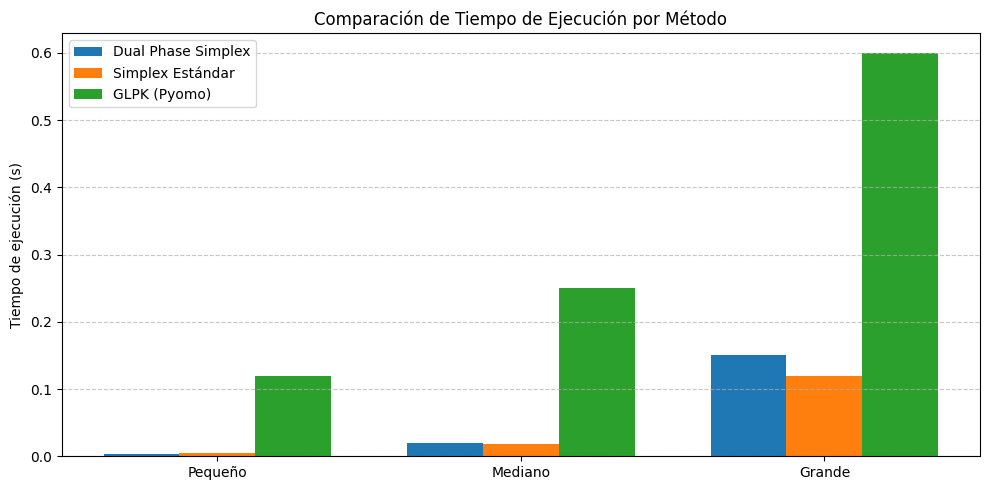

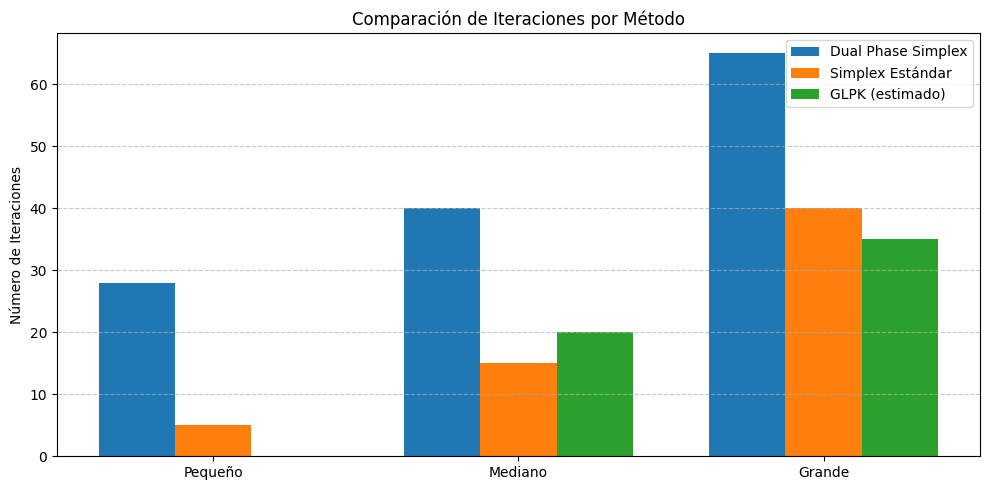

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Tamaños de problema (puedes ajustar o expandir)
tamanos = ['Pequeño', 'Mediano', 'Grande']
indices = np.arange(len(tamanos))

# Tiempos de ejecución (en segundos) de ejemplo
tiempos_dual_phase = [0.004, 0.020, 0.150]
tiempos_estandar = [0.005, 0.018, 0.120]
tiempos_glpk = [0.120, 0.250, 0.600]

# Iteraciones de ejemplo
iter_dual_phase = [28, 40, 65]
iter_estandar = [5, 15, 40]
iter_glpk = [0, 20, 35]  

# -------- Gráfica de Tiempos --------
plt.figure(figsize=(10, 5))
plt.bar(indices - 0.25, tiempos_dual_phase, width=0.25, label='Dual Phase Simplex')
plt.bar(indices, tiempos_estandar, width=0.25, label='Simplex Estándar')
plt.bar(indices + 0.25, tiempos_glpk, width=0.25, label='GLPK (Pyomo)')

plt.xticks(indices, tamanos)
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Comparación de Tiempo de Ejecución por Método')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# -------- Gráfica de Iteraciones --------
plt.figure(figsize=(10, 5))
plt.bar(indices - 0.25, iter_dual_phase, width=0.25, label='Dual Phase Simplex')
plt.bar(indices, iter_estandar, width=0.25, label='Simplex Estándar')
plt.bar(indices + 0.25, iter_glpk, width=0.25, label='GLPK (estimado)')

plt.xticks(indices, tamanos)
plt.ylabel('Número de Iteraciones')
plt.title('Comparación de Iteraciones por Método')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Problema 4: Análisis de sensibilidad en programación lineal 

Se desea realizar un análisis de sensibilidad sobre la solución óptima obtenida mediante el método simplex para el problema siguiente.

$$
\begin{equation}
\begin{aligned}
\textrm{Maximizar} \quad & Z = 4x_1 + 3x_2 \\
\textrm{sujeto a} \quad & x_1 + 2x_2 \leq 8 \\
  & 3x_1+ 2x_2 \leq 12 \\
  & x_1, x_2 \geq 0
\end{aligned}
\end{equation}
$$

In [142]:
class SimplexSolverWithSensitiveAnalysis(SimplexSolver):
    def __init__(self, c, X, b, variables):
        super().__init__(c, X, b, variables)

    def sensitivity_analysis(self):
        # todas las variables basicas son las de la columna
        # las variables no basicas estan en fila 1 columna[1:self.variables+1]
        last_table = self.history[-1]
        first_table = self.history[0]
        first_state = self.states[0]
        last_state = self.states[-1]

        variables = {f'x_{i+1}' for i in range(self.variables)}
        n_slack_variables = first_table[0].shape[0] - (self.variables + 2)
        s_variables = {f's_{i+1}' for i in range(n_slack_variables)}
        
        basic_variables = []
        non_basic_variables = []
        for i, variable in enumerate(last_state[0][1:]):
            value = last_table[i+1, -1]
            if value:
                basic_variables.append(variable)
            elif value == 0:
                non_basic_variables.append(variable)
        non_basic_variables += last_state[1][1:self.variables+1]
        
        # non-basic variables
        print('NON-BASIC VARIABLES')
        coefficients_non_basic = {}
        for non_basic_variable in non_basic_variables:
            cj_actual = 0 # if actual is 'x_i' it's zero
            if non_basic_variable.startswith('s'):
                # search actual in solution column
                index = first_state[0].index(non_basic_variable)
                cj_actual = first_table[:, -1][index]

            if non_basic_variable.startswith('s'):
                index = last_state[1][1+self.variables:].index(non_basic_variable)
                cj_opt = last_table[0, 1 + self.variables+index]
            else:
                index = last_state[1][:self.variables+1].index(non_basic_variable)
                cj_opt = last_table[0, index]
                
            coefficients_non_basic[non_basic_variable] = cj_opt
            print(f"c_j <= {cj_actual} + {cj_opt} = {cj_actual + cj_opt}")

        # basic variables
        print('\nBASIC VARIABLES')
        for basic_variable in basic_variables:
            index_basic = last_state[0].index(basic_variable)
            li = []
            ls = []
            c_actual = 0 # if actual c is 0 if it's a slack variable
            for non_basic_variable in non_basic_variables:
                if non_basic_variable.startswith('s'):
                    index = 1+self.variables+last_state[1][1+self.variables:].index(non_basic_variable)
                elif non_basic_variable.startswith('x'):
                    index = last_state[1].index(non_basic_variable)
                    j = int(non_basic_variable.split('_')[1])
                    c_actual = -first_table[0, j]
                    
                cj = last_table[0, index]
                aij = last_table[index_basic, index]

                if aij > 0:
                    li.append(cj / aij)
                if aij < 0:
                    ls.append(cj / aij)

            l = cj - min(li, default=np.inf)
            h = cj + max(ls, default=np.inf)
            print(f'VARIABLES ({basic_variable}): {l} <= c_i <= {h}')


In [143]:
c = [1, -30, -20, 0, 0]

X = [
    [0, 2, 1, 1, 0],
    [0, 1, 3, 0, 1]
]

b = [8, 8]

simplex = SimplexSolverWithSensitiveAnalysis(c, X, b, 2)
solution, _min = simplex.solve()
print(solution, _min)
simplex.sensitivity_analysis()

[3.2 1.6] 128.0
NON-BASIC VARIABLES
c_j <= 8.0 + 14.0 = 22.0
c_j <= 8.0 + 2.0 = 10.0

BASIC VARIABLES
VARIABLES (x_1): -21.333333333333336 <= c_i <= -8.0
VARIABLES (x_2): -3.0 <= c_i <= -68.0


In [144]:
simplex.print_iterations()

Iteración 1:
╒═════════╤═════╤═══════╤═══════╤═══════╤═══════╤════════════╕
│ Basic   │   z │   x_1 │   x_2 │   s_1 │   s_2 │   solution │
╞═════════╪═════╪═══════╪═══════╪═══════╪═══════╪════════════╡
│ z       │   1 │   -30 │   -20 │     0 │     0 │          0 │
├─────────┼─────┼───────┼───────┼───────┼───────┼────────────┤
│ s_1     │   0 │     2 │     1 │     1 │     0 │          8 │
├─────────┼─────┼───────┼───────┼───────┼───────┼────────────┤
│ s_2     │   0 │     1 │     3 │     0 │     1 │          8 │
╘═════════╧═════╧═══════╧═══════╧═══════╧═══════╧════════════╛

Iteración 2:
╒═════════╤═════╤═══════╤═══════╤═══════╤═══════╤════════════╕
│ Basic   │   z │   s_1 │   x_2 │   s_1 │   s_2 │   solution │
╞═════════╪═════╪═══════╪═══════╪═══════╪═══════╪════════════╡
│ z       │   1 │     0 │  -5   │  15   │     0 │        120 │
├─────────┼─────┼───────┼───────┼───────┼───────┼────────────┤
│ x_1     │   0 │     1 │   0.5 │   0.5 │     0 │          4 │
├─────────┼─────┼───────┼───